In [1]:
import pandas as pd
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np


In [4]:
#ubicaion del archivo csv del dataset 
data= pd.read_csv('D://TrabajoGrado//CodiDatos//archive//Folds.csv')

#Antes del procesamiento 
print(data)

#Renombra la columna filename a path 
data= data.rename(columns={'filename':'path'})


#Crea una nueva columna label 
data['label'] = data.path.apply(lambda x: x.split('/')[3])

#convertir etiquetas a indices enteros 
class_names = ['benign', 'malignant']
data['label_int'] = data.label.apply(lambda x: class_names.index(x))


#crea nueva columna con el nombre filename 
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])



data.head(3)



       fold  mag    grp                                           filename
0         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4         1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
...     ...  ...    ...                                                ...
39540     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39541     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39542     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39543     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39544     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...

[39545 rows x 4 columns]


,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-003.png


In [5]:
# Definir el porcentaje a renombrar (por ejemplo, 20%)
percentage_to_rename = 0.8  # 80%

# Supongamos que quieres renombrar la columna 'column_name'
column_name = 'grp'

# Filtrar las filas que contienen la palabra 'test'
test_rows = data[data[column_name].str.contains('test', na=False)]

# Obtener los índices de estas filas
test_indices = test_rows.index

# Calcular el número de filas a renombrar
num_rows_to_rename = int(len(test_indices) * percentage_to_rename)

# Si el número de filas a renombrar es 0, salimos
if num_rows_to_rename == 0:
    raise ValueError("El porcentaje especificado resulta en cero filas para renombrar.")

# Seleccionar aleatoriamente los índices a renombrar
indices_to_rename = np.random.choice(test_indices, num_rows_to_rename, replace=False)

# Cambiar los valores de las filas seleccionadas a 'vali'
data.loc[indices_to_rename, column_name] = 'vali'

# Verificar los cambios
print(data.head())

   fold  mag    grp                                               path  \
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   

    label  label_int                        filename  
0  benign          0  SOB_B_A-14-22549AB-100-001.png  
1  benign          0  SOB_B_A-14-22549AB-100-002.png  
2  benign          0  SOB_B_A-14-22549AB-100-003.png  
3  benign          0  SOB_B_A-14-22549AB-100-004.png  
4  benign          0  SOB_B_A-14-22549AB-100-005.png  


In [8]:
print(test_indices.size) # el numero de indices de test
data.head(4)

13665


,fold,mag,grp,path,label,label_int,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,benign,0,SOB_B_A-14-22549AB-100-004.png


Count of Benign    :  12400
Count of Malignant :  27145


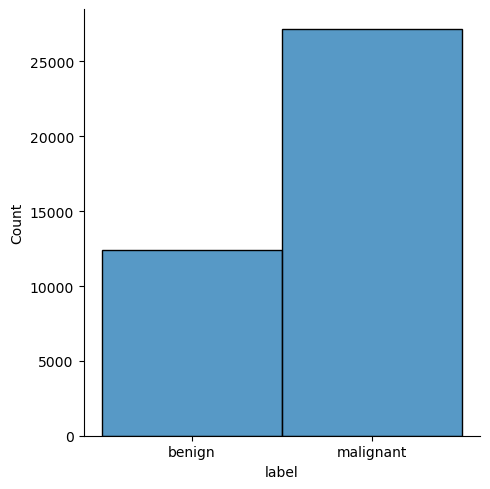

In [10]:
#Grafica de lka division de label del dataset 
ax = sns.displot(data=data, x='label')
print('Count of Benign    : ', data[data.label == 'benign'].label.count())
print('Count of Malignant : ', data[data.label == 'malignant'].label.count())

In [11]:
# Lista de nombres de clases
n_clases = sorted(data['label'].unique())

# Crear un diccionario de mapeo de etiquetas a índices
label_to_index = {label: index for index, label in enumerate(n_clases)}

print(n_clases)
print(label_to_index)

['benign', 'malignant']
{'benign': 0, 'malignant': 1}


In [12]:
# Dataset personalizado
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, label_to_index, transform):
        self.dataframe = dataframe
        self.label_to_index = label_to_index
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['label']
        label_idx = self.label_to_index[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label_idx

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ajustar el tamaño de las imágenes
    transforms.ToTensor(),
    
     #DataAugmentation
    transforms.RandomResizedCrop(224),  # Recorta aleatoriamente la imagen y la redimensiona a 128x128
    transforms.RandomHorizontalFlip(),  # Voltea aleatoriamente la imagen horizontalmente
    transforms.RandomRotation(20),      # Rota la imagen aleatoriamente dentro de un rango de 20 grados
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Crear el Dataset
dataset = CustomImageDataset(dataframe=data, label_to_index=label_to_index, transform=transform)

# Crear un DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
#Funcion para mostrar imagenes del dataset con la transformacioanes 

def show_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.imshow(images[i].permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])
        plt.title(class_names[labels[i]])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.8926551742553711].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9594187214374542].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9170430755615235].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9726727125644684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..0.9987657573223114].
Clip

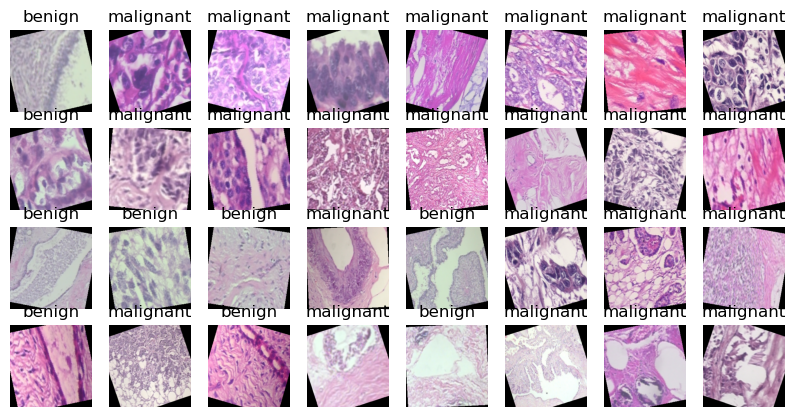

In [15]:
# Obtener un lote de imágenes
data_iter = iter(data_loader)

images, labels = next(data_iter)

# Mostrar las imágenes y etiquetas
show_images(images, labels, n_clases)


train   :  25880
vali :  10932
test :  2733


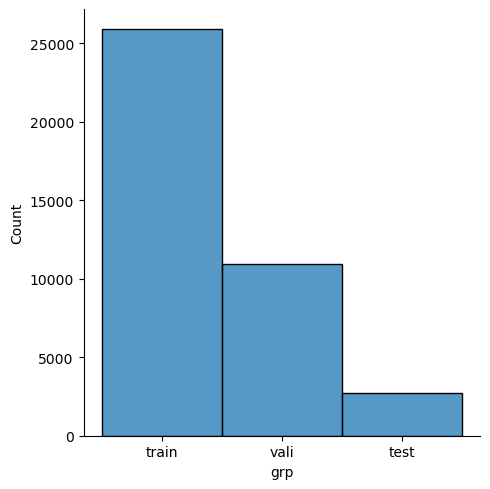

In [16]:
#Grafica de la division del dataset de train, validacion y test

ax = sns.displot(data=data, x='grp')
print('train   : ', data[data.grp == 'train'].label.count())
print('vali : ', data[data.grp == 'vali'].label.count())
print('test : ', data[data.grp == 'test'].label.count())

In [17]:
# Crear el Dataset para train y test
train_data = data[data['grp'].str.contains('train')]
test_data = data[data['grp'].str.contains('test')]
vali_data = data[data['grp'].str.contains('vali')]

# Contar el número de ocurrencias de cada tipo de dato
counts = data['grp'].value_counts()
print(counts)


train_dataset = CustomImageDataset(dataframe=train_data, label_to_index=label_to_index, transform=transform)
test_dataset = CustomImageDataset(dataframe=test_data, label_to_index=label_to_index, transform=transform)
vali_dataset =  CustomImageDataset(dataframe=vali_data, label_to_index=label_to_index, transform=transform)

grp
train    25880
vali     10932
test      2733
Name: count, dtype: int64


In [ ]:
# Crear DataLoaders para train, test y vali
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
vali_loader = DataLoader(vali_dataset, batch_size=32, shuffle=False)


#Apartir de aqui se crean los modelos para entrenar con el Dataloader que se creo 